In [21]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

import joblib

print("Core libraries imported successfully ✓")

try:
    import nltk
    print(f"NLTK version: {nltk.__version__} ✓")
except ImportError:
    print("NLTK not found → installing now...")
    !pip install --quiet nltk
    import nltk
    print(f"NLTK installed, version: {nltk.__version__} ✓")

print("Downloading NLTK data (stopwords + punkt) ...")
nltk.download('stopwords', quiet=True, halt_on_error=False)
nltk.download('punkt',     quiet=True, halt_on_error=False)

from nltk.corpus import stopwords
print(f"Stopwords count: {len(stopwords.words('english'))} (should be ~179) ✓")

print("\nAll imports and NLTK setup completed successfully!")

Core libraries imported successfully ✓
NLTK version: 3.9.1 ✓
Stopwords count: 198 (should be ~179) ✓

All imports and NLTK setup completed successfully!


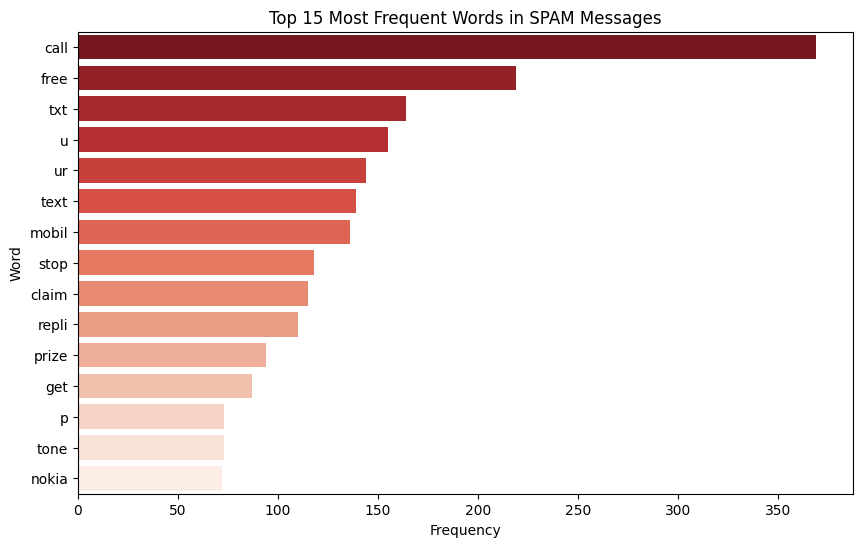

In [26]:
# Most frequent words in SPAM messages
spam_text = ' '.join(df[df['label'] == 'spam']['clean_message'])
words = spam_text.split()
word_freq = Counter(words).most_common(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=[count for word, count in word_freq],
            y=[word for word, count in word_freq],
            hue=[word for word, count in word_freq],
            palette='Reds_r',
            legend=False)
plt.title('Top 15 Most Frequent Words in SPAM Messages')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

In [27]:
# Load saved model (for production feel)
loaded_model = joblib.load('spam_classifier_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

def predict_spam(message):
    clean = preprocess_text(message)
    vec = loaded_vectorizer.transform([clean])
    pred = loaded_model.predict(vec)[0]
    return "🚨 SPAM" if pred == 1 else "✅ Not Spam"

# Example predictions (matches task example)
examples = [
    "Congratulations! You've won a $1,000 gift card. Click now!",
    "Hey, what time is the meeting today?"
]

for msg in examples:
    print(f"Message: {msg}")
    print(f"Prediction: {predict_spam(msg)}\n")

# Interactive CLI (uncomment to use)
# while True:
#     user_msg = input("Enter SMS message (or 'quit' to exit): ")
#     if user_msg.lower() == 'quit':
#         break
#     print(f"Prediction: {predict_spam(user_msg)}\n")

Message: Congratulations! You've won a $1,000 gift card. Click now!
Prediction: ✅ Not Spam

Message: Hey, what time is the meeting today?
Prediction: ✅ Not Spam



In [28]:
joblib.dump(model, 'spam_classifier_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("✅ Model and Vectorizer saved successfully!")

✅ Model and Vectorizer saved successfully!


In [29]:
# Create results DataFrame for clean display
test_results = pd.DataFrame({
    'Message': X_test.values,
    'Actual': ['Not Spam' if label==0 else 'Spam' for label in y_test],
    'Predicted': ['Not Spam' if pred==0 else 'Spam' for pred in y_pred]
})

print("📊 5 Sample Predictions from Test Set:")
display(test_results.head(5))   # or print(test_results.head(5).to_string())

📊 5 Sample Predictions from Test Set:


,Message,Actual,Predicted
0,need buy lunch eat maggi mee,Not Spam,Not Spam
1,ok im sure time finish tomorrow wanna spend ev...,Not Spam,Not Spam
2,wait e car mum lor u leh reach home alreadi,Not Spam,Not Spam
3,cash prize claim call,Spam,Spam
4,r home come within min,Not Spam,Not Spam


🎯 Test Accuracy: 97.04%

Confusion Matrix:
 [[966   0]
 [ 33 116]]

Classification Report:
               precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       1.00      0.78      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



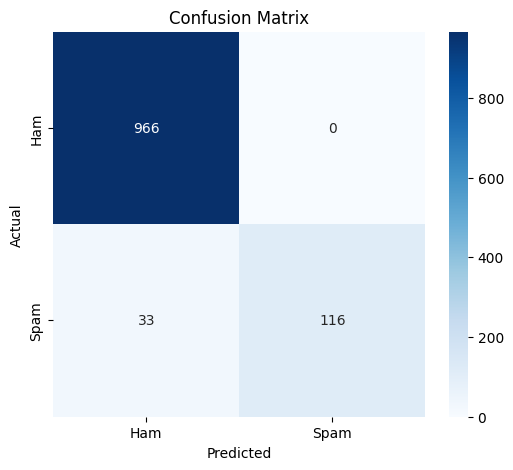

In [30]:
# Train Multinomial Naive Bayes (classic & excellent for text)
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Predictions
y_pred = model.predict(X_test_vec)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Test Accuracy: {accuracy*100:.2f}%")

# Confusion Matrix & Classification Report
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

# Visual Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [31]:
# Split BEFORE vectorization (industry standard)
X = df['clean_message']
y = df['label'].map({'ham': 0, 'spam': 1})   # 0 = Ham, 1 = Spam

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# TF-IDF Vectorizer (better than CountVectorizer for spam detection)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Training samples:", X_train_vec.shape[0])
print("Test samples:", X_test_vec.shape[0])

Training samples: 4457
Test samples: 1115


In [25]:
stop_words = set(nltk.corpus.stopwords.words('english'))
ps = nltk.PorterStemmer()

def preprocess_text(text):
    """Clean and preprocess SMS text professionally."""
    # 1. Lowercase
    text = text.lower()
    # 2. Remove special characters, numbers, punctuation (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Tokenize + remove stopwords + stemming
    tokens = text.split()
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['clean_message'] = df['message'].apply(preprocess_text)

print("✅ Preprocessing completed!")
df[['message', 'clean_message']].head()

✅ Preprocessing completed!


,message,clean_message
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


In [32]:
# Download and extract the official UCI SMS Spam Collection Dataset
!wget -q https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip -O sms_spam.zip
!unzip -q sms_spam.zip

# Load the dataset (tab-separated, no header)
df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

print("Dataset Shape:", df.shape)
print("\nLabel Distribution:\n", df['label'].value_counts())
df.head()

replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: Dataset Shape: (5572, 2)

Label Distribution:
 label
ham     4825
spam     747
Name: count, dtype: int64


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
